In [4]:
!pip install matplotlib

In [1]:
#Roll Rate Analysis based on loans performance
import pandas as pd
import numpy as np
import csv, os, pickle, xlsxwriter, gc, calendar
import openpyxl as pxl
import matplotlib.pyplot as plt
from collections import Counter
import math

In [2]:
#create output file
outfile = os.path.expanduser("Roll Rate/MOB.csv")
## Order by Loan ID & File Date
loanfile = "Roll Rate/Monthly Loans Info.csv"
loan = pd.read_csv(loanfile, header=0, skiprows=[1], index_col=False, na_filter=True)
loan['file_date'] = pd.to_datetime(loan['file_date'])
loan.sort_values(by = ['LoanId','file_date'], ascending=True, inplace=True)
loan = loan.reset_index(drop=True)

In [4]:
## Create MOB
loan['mob'] = 0
prev_ID, prev_mob = None, 0
for i, (loanID, mobn) in enumerate(zip(loan['LoanId'], loan['mob'])):
    if prev_ID == loanID:
        if prev_mob > 0:
            mobn = loan.at[i, 'mob'] = prev_mob +1 
        elif (loan['repay_lbl'][i] == 2) or (loan['repay_lbl'][i] == 1):
            mobn = loan.at[i, 'mob'] = 1
        
        prev_mob = mobn
    else:
        if (loan['repay_lbl'][i] == 2) or (loan['repay_lbl'][i] == 1):
            mobn = loan.at[i, 'mob'] = 1
            prev_mob = mobn
        else:
            prev_mob  = 0
    prev_ID = loanID
#     print(i, mobn)

In [31]:
outfile = os.path.expanduser("Roll Rate/mobnew.csv")
loan.to_csv(outfile, index=False, encoding='utf-8')

In [5]:
mobfile = 'Roll Rate/MOB.csv'
mob = pd.read_csv(mobfile, header=0, skiprows=[1], index_col=False, na_filter=True)

# Decide if delinquent days > 120 (for vintage analysis)
loan['d120'] = 0
if loan['DaysDelinquent'][0] > 120:
    loan['d120'] = 1
for i in range(1,len(loan['LoanId'])):
    if loan['LoanId'][i-1] == loan['LoanId'][i]:
        if loan['d120'][i-1] == 1:
            loan['d120'][i] = loan['d120'][i-1]
        elif loan['DaysDelinquent'][i] > 120:
            loan['d120'][i] = 1
#         print(i)

In [390]:
# Calculate delinquent period
loan['dp'] = np.ceil(loan['DaysDelinquent'] / 30)
# print(max(mob['dp']))
loan.to_csv(outfile, index=False, encoding='utf-8')

In [3]:
# Get MOB file
mobfile = "Roll Rate/MOB.csv"
mob = pd.read_csv(mobfile, header=0, skiprows=[1], index_col=False, na_filter=True)


    mob  cnts  ccnts    %c
27   28     1      1  0.00
26   27     1      2  0.00
25   26    11     13  0.02
24   25     7     20  0.03
23   24     6     26  0.04
22   23     6     32  0.05
21   22     6     38  0.06
20   21    40     78  0.12
19   20    14     92  0.15
18   19    19    111  0.18
17   18    13    124  0.20
16   17    11    135  0.22
15   16    12    147  0.23
14   15    14    161  0.26
13   14    38    199  0.32
12   13    18    217  0.35
11   12    10    227  0.36
10   11    14    241  0.38
9    10    18    259  0.41
8     9   168    427  0.68
7     8    28    455  0.73
6     7    14    469  0.75
5     6    16    485  0.77
4     5    10    495  0.79
3     4     3    498  0.79
2     3     7    505  0.81
1     2   112    617  0.98
0     1    10    627  1.00


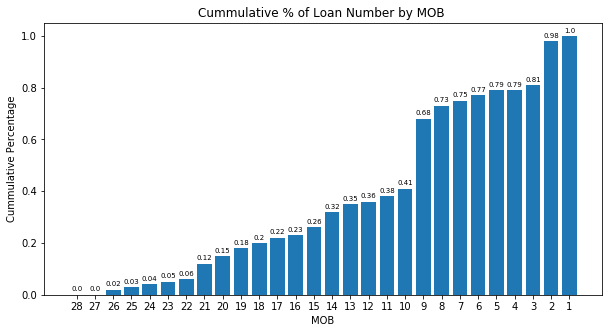

In [7]:
## Roll Rate Analysis

## Get the period we should choose

# get loans month in repayment until now
loanid = []
monthinrepay = []
for i in range(1,len(mob['LoanId'])):
    if mob['LoanId'][i-1] != mob['LoanId'][i]:
        if mob['mob'][i-1] != 0:
            loanid.append(mob['LoanId'][i-1])
            monthinrepay.append(mob['mob'][i-1])
if mob['mob'].iloc[-1] != 0:
    loanid.append(mob['LoanId'].iloc[-1])
    monthinrepay.append(mob['mob'].iloc[-1])
monthinrepay.sort()

# pick certain period for roll rate
mcount = Counter(monthinrepay)
df = pd.DataFrame.from_dict(mcount, orient='index').reset_index()
df.columns = ['mob', 'cnts']
df.sort_values('mob', ascending=False, inplace=True)
df['ccnts'] = df['cnts'].cumsum()
df['%c'] = round(df['ccnts'] / df['cnts'].sum(),2)
print(df)

# Draw bar plot.
indexes = np.arange(len(df['mob']))
ax = plt.subplots(figsize=(10,5))
plt.bar(indexes, df['%c'], linewidth = 5)
plt.xticks(indexes, df['mob'])
plt.xlabel("MOB")
plt.ylabel("Cummulative Percentage")
plt.title("Cummulative % of Loan Number by MOB ")
for i,c in enumerate(df['%c']):
    plt.text(indexes[i], c + 0.01, c, va= 'bottom',fontsize=7, ha='center')
plt.show()

#From the plot, we can choose 9 as the period: after 5M & after 9M

In [566]:
pmonth = 9
fmonth = 5 #you can change to any number you want to see the change of result

## get loans MOB >= 9, 427 loans
pickedloan = mob.loc[mob['mob'] == pmonth,'LoanId']

# Build loan number table: delinquent performance after 5 months in repayment & after 9 months in repayment
Dlq = ['No Due', '0-29 DPD', '30-59 DPD', '60-89 DPD', '90-119 DPD', '> 120 DPD']
rolln = pd.DataFrame(Dlq, columns = ['Dlq'])
rolln['No Due'] = 0
rolln['0-29 DPD'] = 0
rolln['30-59 DPD'] = 0
rolln['60-89 DPD'] = 0
rolln['90-119 DPD'] = 0
rolln['> 120 DPD'] = 0
rolln['Total'] = 0

#d120 loan number
for j in range(len(rollr['Dlq'])):  
    if j < len(rolln['Dlq'])-1:
        ploan = mob.loc[mob['LoanId'].isin(pickedloan) & (mob['mob'] == fmonth) & (mob['dp'] == j),'LoanId']
        rolln['Total'][j] = len(ploan)
        for i in range(1,len(rolln.columns)-2):
            rolln.iloc[j,i] = mob.loc[mob['LoanId'].isin(ploan) & (mob['mob'] == pmonth) & (mob['dp'] == i-1),'LoanId'].count()
        rolln.iloc[j,len(rolln.columns)-2] = mob.loc[mob['LoanId'].isin(ploan) & (mob['mob'] == pmonth) & (mob['dp'] >= 5),'LoanId'].count()    
#         print("j=",j,"i=",i,"re",rollr.iloc[j,i])
#         print(rollr['status on 3M'][j])
    else:
        ploan = mob.loc[mob['LoanId'].isin(pickedloan) & (mob['mob'] == fmonth) & (mob['dp'] >= 5),'LoanId']
        rolln['Total'][j] = len(ploan)
        for i in range(1,len(rolln.columns)-2):
            rolln.iloc[j,i] = mob.loc[mob['LoanId'].isin(ploan) & (mob['mob'] == pmonth) & (mob['dp'] == i-1),'LoanId'].count()
        rolln.iloc[j,len(rolln.columns)-2] = mob.loc[mob['LoanId'].isin(ploan) & (mob['mob'] == pmonth) & (mob['dp'] >= 5),'LoanId'].count()    

rolln

,Dlq,No Due,0-29 DPD,30-59 DPD,60-89 DPD,90-119 DPD,> 120 DPD,Total
0,No Due,232,15,10,4,5,2,268
1,0-29 DPD,16,2,0,1,2,2,23
2,30-59 DPD,6,1,0,0,1,6,14
3,60-89 DPD,16,3,0,0,0,9,28
4,90-119 DPD,24,2,0,1,0,40,67
5,> 120 DPD,4,0,0,1,0,22,27


In [567]:
# Build Roll Rate Table
rollr = rolln.copy()
rollr = rollr.drop(columns = ['Total'])
rollr['Roll Back'] = 0.0 # Delinquency better
rollr['Roll Forward'] = 0.0 # Delinquency worse
for j in range(len(rollr['Dlq'])):
    for i in range(1,len(rollr.columns)-2):
        rollr.iloc[j,i] = round(rolln.iloc[j,i] / rolln.iloc[j,-1],4)
for i in range(len(rollr['Dlq'])):
    rollr['Roll Forward'][i] = round(rollr.iloc[i,(i+2):len(rollr['Dlq'])+1].sum(),4)
    rollr['Roll Back'][i] = round(rollr.iloc[i,1:(i+1)].sum(),4)
#     print(i,rollr['Roll Back'][i])
rollr
    

,Dlq,No Due,0-29 DPD,30-59 DPD,60-89 DPD,90-119 DPD,> 120 DPD,Roll Back,Roll Forward
0,No Due,0.8657,0.0560,0.0373,0.0149,0.0187,0.0075,0.0000,0.1344
1,0-29 DPD,0.6957,0.0870,0.0000,0.0435,0.0870,0.0870,0.6957,0.2175
2,30-59 DPD,0.4286,0.0714,0.0000,0.0000,0.0714,0.4286,0.5000,0.5000
3,60-89 DPD,0.5714,0.1071,0.0000,0.0000,0.0000,0.3214,0.6785,0.3214
4,90-119 DPD,0.3582,0.0299,0.0000,0.0149,0.0000,0.5970,0.4030,0.5970
5,> 120 DPD,0.1481,0.0000,0.0000,0.0370,0.0000,0.8148,0.1851,0.0000
